# Universal Differential Equation for a 2D PDE heat equation

In [1]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate()
using Plots; gr()
using Statistics
using LinearAlgebra
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


### Parameter declaration

In [2]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.01
t₁ = 1

D₀ = 1
tolnl = 1e-4
itMax = 100
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1

0.24390243902439027

## Generate reference dataset

In [3]:
T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ];

T₁ = copy(T₀);


In [11]:
# Patch suggested by Michael Abbott needed in order to correctly retrieve gradients
Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

function train(loss, p)
    
    leakyrelu(x, a=0.01) = max(a*x, x)
    relu(x) = max(0, x)
    sigmoid_D(x) = .5 + 10 / ( 1 + exp(-x) ) 

    UA = Chain(
        Dense(1,10,initb = Flux.zeros), 
        BatchNorm(10, leakyrelu),
        Dense(10,5,initb = Flux.zeros), 
        BatchNorm(5, leakyrelu),
        Dense(5,1, relu, initb = Flux.zeros) 
    )
    # UD = Chain(
    #     Dense(1,10,initb = Flux.glorot_normal), 
    #     Dense(10, 5, x->σ.(x), initb = Flux.glorot_normal),
    #     #BatchNorm(5, sigmoid),
    #     #Dense(5,1, sigmoid_D, initb = Flux.glorot_normal) 
    #     Dense(5, 1, x->σ.(x), initb = Flux.glorot_normal)
    # )
    
    
    opt = ADAM(0.8)
    losses = []
    @epochs 50 hybrid_train_NN!(loss, UA, p, opt, losses)
    
    return UD, losses
    
end

function hybrid_train_NN!(loss, UA, p, opt, losses)
    
    T = T₀
    θ = Flux.params(UA)
    loss_UA, back_UA = Zygote.pullback(() -> loss(T, UA, p), θ)
    push!(losses, loss_UA)
    
    println("Current loss: ", loss_UA)
    #println("Current parameter:", θ)
    ∇_UA = back_UA(one(loss_UA))

    #for p in θ
    #    println("Gradients ∇_uD[p]: ", ∇_uD[p])
    #end
    
    # println("Values of NN: ", UD([0., .5, 1.]'))
    all_times = LinRange(0, t₁, 1000)
    #plot(all_times, UD(all_times')')
    
    Flux.Optimise.update!(opt, θ, ∇_UA)
    
    
end

sqnorm(x) = sum(abs2, x)

function loss_NN(T, UA, p, λ=1)

    T = heatflow_NN(T, UA, p)
    l_cost = sqrt(Flux.Losses.mse(T, T_ref; agg=mean))
    #l_reg  = sum(sqnorm, ps)

    return l_cost #+ λ * l_reg
end

loss_NN (generic function with 2 methods)

So far the gradients are correctly computed, and the neural network is capable of learning something.

Now we need to add progressively add complexity, turning this closer to the Shallow Ice Approximation in order to break it and reproduce the original issue. 


## Reproducing the iceflow issue

In [5]:
# Utility functions
@views avg(A) = 0.25 * ( A[1:end-1,1:end-1] .+ A[2:end,1:end-1] .+ A[1:end-1,2:end] .+ A[2:end,2:end] )

@views avg_x(A) = 0.5 .* ( A[1:end-1,:] .+ A[2:end,:] )

@views avg_y(A) = 0.5 .* ( A[:,1:end-1] .+ A[:,2:end] )

avg_y (generic function with 1 method)

### Nonlinear version of the `Heat()` and `iceflow()` functions to be used with a fake `A` law

In [6]:
function Heat_nonlinear(T, A, p)
   
    Δx, Δy, Δt, t₁, ρ, g, n = p
    
    #### NEW CODE TO BREAK
    dTdx = diff(T, dims=1) / Δx
    dTdy = diff(T, dims=2) / Δy
    ∇T = sqrt.(avg_y(dTdx).^2 .+ avg_x(dTdy).^2)

    # Γ = 1/ (50*A ^(n+2))
    # D = Γ .* avg(T).^n .* ∇T
    D = A .* avg(T) .* ∇T
    # println("D max: ", maximum(D))
    # println("D min: ", minimum(D))
    ####

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
   
    Fx = -avg_y(D) .* dTdx_edges
    Fy = -avg_x(D) .* dTdy_edges   
    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min.( 10.0 , 1.0./(1.0/Δt .+ 1.0./(cfl./(ϵ .+ avg(D)))))
    
    return F, dτ
 
end


function heatflow_nonlinear(T, fA::Function, p, tol=Inf)
   
    Δx, Δy, Δt, t₁, ρ, g, n = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            A = fA(t)  # compute the fake A value involved in the nonlinear diffusivity
            # println("t: ", t)
            # println("A: ", A)
            # if iter == 1
            #     println("current D: ", D)
            # end
            
            F, dτ = Heat_nonlinear(T, A, p)

            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]

            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow_nonlinear (generic function with 2 methods)

We generate a reference dataset using the `fakeA()` law

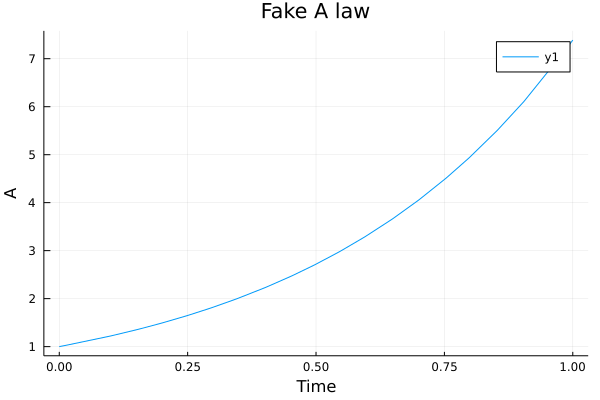

In [7]:
A₀ = 1
ρ = 9
g = 9.81
n = 3
p = (Δx, Δy, Δt, t₁, ρ, g, n)  # we add extra parameters for the nonlinear diffusivity

fakeA(t) = A₀ * exp(2t)

plot(fakeA, 0, t₁, title="Fake A law", xaxis="Time", yaxis="A")

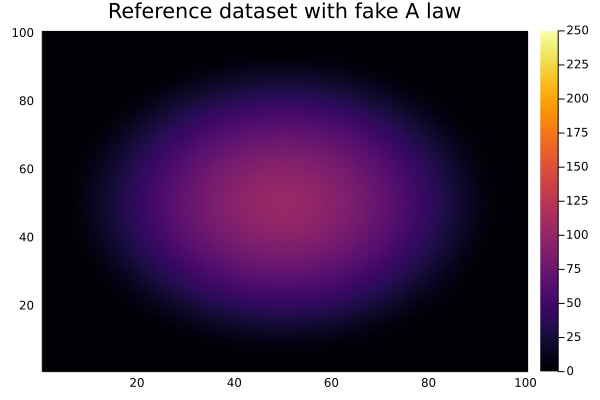

In [8]:

T₂ = copy(T₀)
T_ref = heatflow_nonlinear(T₂, fakeA, p, 1e-1)

heatmap(T_ref, clim=(0, maximum(T₀)), title="Reference dataset with fake A law")

Now we try to reproduce `fakeA` with a NN

In [9]:
function heatflow_NN(T, UA, p, tol=Inf)
   
    Δx, Δy, Δt, t₁, ρ, g, n = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            A = UA([t]')[1]  # compute A parameter involved in the diffusivity
            # println("A: ", A)

            #println(D)
            F, dτ = Heat_nonlinear(T, A, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow_NN (generic function with 2 methods)

In [13]:
UA_trained, losses = train(loss_NN, p)

┌ Info: Epoch 1
└ @ Main /Users/Bolib001/.julia/packages/Flux/0c9kI/src/optimise/train.jl:135


LoadError: MethodError: no method matching loss_NN(::Matrix{Float64}, ::Chain{Tuple{Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, BatchNorm{var"#leakyrelu#46", Vector{Float32}, Float32, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, BatchNorm{var"#leakyrelu#46", Vector{Float32}, Float32, Vector{Float32}}, Dense{var"#relu#47", Matrix{Float32}, Vector{Float32}}}}, ::Tuple{Int64, Int64, Float64, Int64, Int64, Float64, Int64})
[0mClosest candidates are:
[0m  loss_NN(::Any, ::Any, ::Any, [91m::Any[39m) at In[11]:60
[0m  loss_NN(::Any, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m) at In[11]:60

In [ ]:
plot(losses)

In [ ]:
UA_trained([0.4]')

In [ ]:
plot(UA_trained, 0, t₁, title="UA", xaxis="Time", yaxis="A")